# Txomin Bornaetxea: Modeling debris flow source areas
[Video recording](https://youtu.be/R_GluB9DEz0)

## **1.0 Objectives of the project**

Debris flows are a particular type of landslides that are able to transport a large amount of sediments down the slope. Commonly they present three different functional zones: *source*, *transportation* and *deposition*. 

The objective of this project is to generate numerical models that predict the probability of a given pixel to be a debris flow souce zone. 
The study area for this case is placed in the Rocky Mountains of British Columbia, Canada, were medium to high mountains landscpe shows a historical landslide prone conditions. 

The basic input data are: 

* A polygon **shapefile** containing a large amount of landslides of different type, including debris flow separated by the functional zones.  
* A set of digital elevation layers in **tif** format provided by different sources. 
 

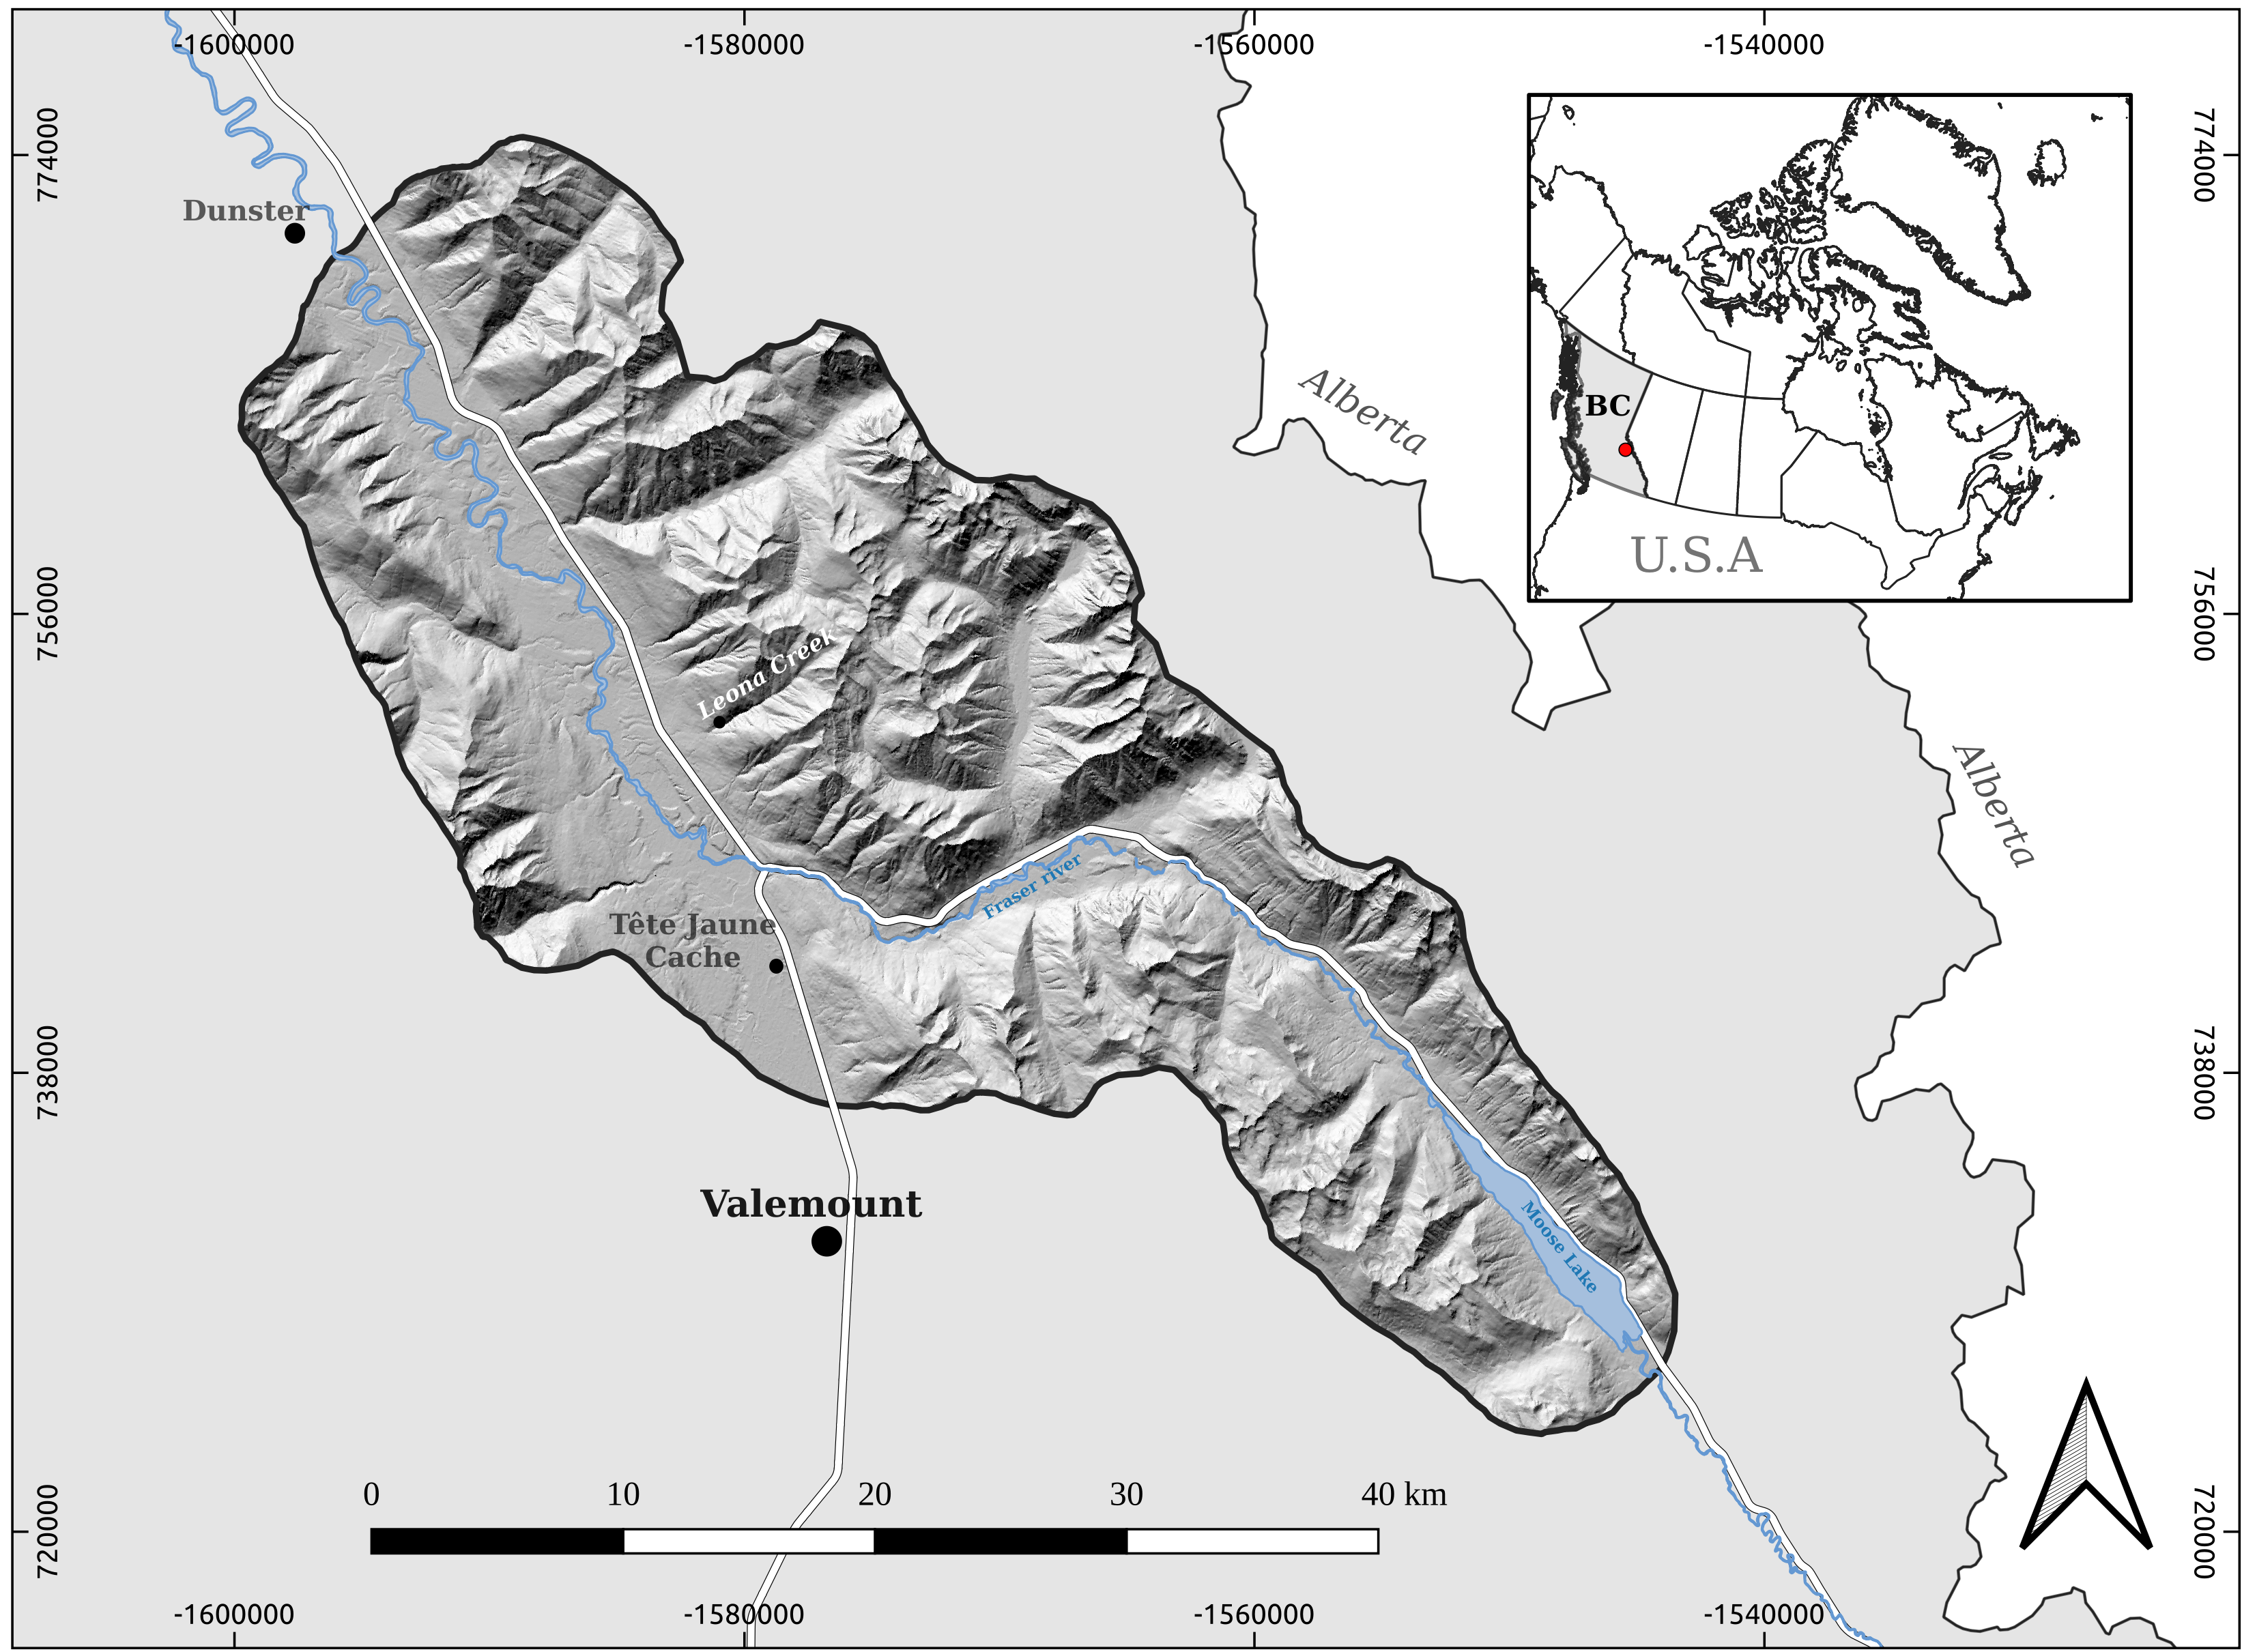

In [1]:
from IPython.display import Image
Image("/home/txomin/LVM_shared/Project/Figures/Fig_1_Location_map.png" , width = 500, height = 300)

## **2.0 Data Pre-Processing**

### 2.1- DEM EXPLORATION AND COMPOSITION

The eastern part of the study area is covered by a DEM data set generated with LiDAR data and provided in smaller tiles with resolution 1x1 meterr. These files are in ESRI binary format *.adf*. Therefore we carried out a merging and resampling processes in order to obtain one single DEM:

In [ ]:
%%bash

mkdir TIF_files

for i in $(ls -1 | grep -v TIF_files); do

input=$(echo $i/w001001.adf)

output=$(echo TIF_files/${i}.tif)

gdal_translate -a_srs EPSG:2955 -of GTiff $input $output;

done

gdal_merge.py -ot Float32 -of GTiff -o mooselake_merged_1x1.tif TIF_files/*.tif

gdal_translate mooselake_merged_1x1.tif mooselake_merged_5x5.tif -tr 5 5

On the other hand, for the western part of the study area only the native LiDAR *.laz* files were provided. In order to generate a 5x5 *.tif* file we carried out the following work flow using ***pdal*** and ***gdal*** libraries: 

* *The complete process spent ~ 10 hours on the server [1635 .laz files]* 

In [ ]:
%%bash

# Band 1 = min; Band 2 = max; Band 3 = mean; Band 4 = idw; Band 5= count; Band 6 = stdev

band_num=1  

file_list=''

# Loop to extract only class 2 points (ground points) from LAZ files

for i in *.laz   

do
    echo $i
    
    name=$(echo $i | cut -f1 -d'.')
    
    name=$name"_class2.laz"
    
    pdal translate $i $name --json class_2_filter.json
    
    # Append the name of each file like file1 file2 file3 ...
    
    file_list=`echo "$file_list $name"`    
    
    echo $file_list 
    
done

# merge all the LAZ files that contain only class 2 points into one single file

pdal merge $file_list merged_file.laz 


#to define the coordinate system

pdal pipeline proj_deff.json 

# generate the multiband raster file with the measured values within each pixel with 2.5x2.5

pdal pipeline to_raster.json 

# resample the final dtm to 5x5 resolution

gdal_translate dtm_2_5_.tif dtm_5_.tif -tr 5 5

# fill the void pixels by IDW interpolation

gdal_fillnodata.py -md 20 -of GTiff dtm_5_.tif dtm_5_idw.tif

Once we have the two DEM files **dtm_5_idw.tif** [western part] and **mooselake_merged_5x5.tif** [eastern part], we are going to verify that their NaData value and data Type are identical:

In [2]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/dtm/
for i in $(echo "dtm_5_idw.tif mooselake_merged_5x5.tif"); do echo $i; gdalinfo $i | grep NoData; done
echo ""
for i in $(echo "dtm_5_idw.tif mooselake_merged_5x5.tif"); do echo $i; gdalinfo $i | grep Type; done
echo ""
for i in $(echo "dtm_5_idw.tif mooselake_merged_5x5.tif"); do echo $i; gdalinfo $i | grep Pixel; done

dtm_5_idw.tif
  NoData Value=-9999
mooselake_merged_5x5.tif
  NoData Value=-9999

dtm_5_idw.tif
Band 1 Block=14618x1 Type=Float64, ColorInterp=Gray
mooselake_merged_5x5.tif
Band 1 Block=5804x1 Type=Float64, ColorInterp=Gray

dtm_5_idw.tif
Pixel Size = (5.000000000000000,-5.000000000000000)
mooselake_merged_5x5.tif
Pixel Size = (5.000000000000000,-5.000000000000000)


Since everything seem to be correct, we combined the two layer in one single DEM using **pk_composite** and considering the average value when there are overlapping pixels. 

* ***Actually a more complex cleaning procedure was needed but for the sake of the example lets pretend this ideal situation*** **:-)**
* Indeed, I had to use also ***gdal_edit.py***, ***pkreclass***, ***gdal_calc.py***  ...

In [ ]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/dtm/
pkcomposite -i mooselake_merged_5x5.tif -i dtm_5_idw.tif -o /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation2.tif -srcnodata -9999 -dstnodata -9999 -cr meanband
cd /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/
gdal_edit.py -a_nodata -9999 elevation2.tif
gdalinfo -mm elevation2.tif

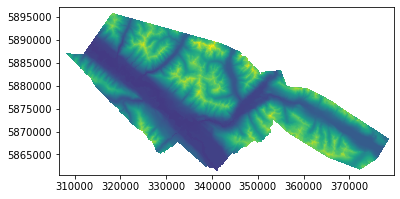

In [3]:
import rasterio
from rasterio import *
from rasterio.plot import show
from rasterio.plot import show_hist
raster = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation2.tif")
rasterio.plot.show(raster)

### 2.2- LANDSLIDE INVENTORY EXPLORATION AND EXTRACTION OF SOURCE ZONES 

Now we are going to explore the information contained in the landslide inventoy shapefile.

In [4]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/
ogrinfo -so Valemount_landslide_inventory_2022.shp Valemount_landslide_inventory_2022 | grep Count
ogrinfo -so Valemount_landslide_inventory_2022.shp Valemount_landslide_inventory_2022 | tail -10

Feature Count: 2191
Data axis to CRS axis mapping: 1,2
id: Integer64 (10.0)
Lnds_name: String (80.0)
Lnds_zone: String (80.0)
Type: String (80.0)
Ortho_1x1: String (10.0)
Google: String (10.0)
LiDAR: String (10.0)
Confidence: Integer64 (10.0)
Channelize: String (10.0)


Next step is to extract only the polygons classified as "debris flow" and save just those classified as "source" zones. 

In [5]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/
ogr2ogr -sql "SELECT * FROM Valemount_landslide_inventory_2022 WHERE Type='debris flow' AND Lnds_zone='source'" debris_flow_sources_2.shp Valemount_landslide_inventory_2022.shp
ogrinfo -so debris_flow_sources_2.shp debris_flow_sources_2 | grep Count
ogrinfo -so debris_flow_sources_2.shp debris_flow_sources_2 | tail -10

Feature Count: 463
Data axis to CRS axis mapping: 1,2
id: Integer64 (10.0)
Lnds_name: String (80.0)
Lnds_zone: String (80.0)
Type: String (80.0)
Ortho_1x1: String (10.0)
Google: String (10.0)
LiDAR: String (10.0)
Confidence: Integer64 (10.0)
Channelize: String (10.0)


Text(0.5, 1, 'Source Inventory')

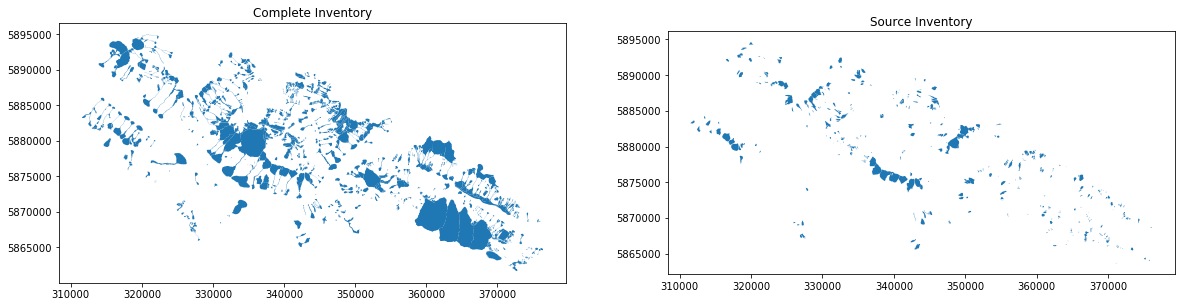

In [6]:
import geopandas
from matplotlib import pyplot
inventory = geopandas.read_file("/home/txomin/LVM_shared/Project/Valemount_data/Valemount_landslide_inventory_2022.shp")
inventory_sources = geopandas.read_file("/home/txomin/LVM_shared/Project/Valemount_data/debris_flow_sources_2.shp")
fig, (ax1,ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = inventory.plot(ax=ax1)
ax1.set_title("Complete Inventory")
ax2 = inventory_sources.plot(ax=ax2)
ax2.set_title("Source Inventory")


### 2.3- GENERARION OF THE SPATIAL VARIABLES

At this point we need a set of raster maps from which we are going to extract the different variables for the data set generation. 
* It is very important that all the raster maps have the same size and are correctly aligned so all the pixels overlap perfectly.
* The dependent variable (**source inventory**) has to be in perfect alignement as well. 

We are going to use the **pyjeo** library to prepare the final inventory raster layer where:
* The value of 0 is given to all the pixels in the DEM that do NOT contain a debris flow source area.
* The value of 1 is given to all the pixels in the DEM that do NOT contain a debris flow source area.
* NoData value (-9999) are given to the valley bottom plain areas. Those where manually defined by a polygon shapefile.  


In [ ]:
import pyjeo as pj
from matplotlib import pyplot as plt
import numpy as np
sources ='/home/txomin/LVM_shared/Project/Valemount_data/debris_flow_sources_2.shp'
plains = '/home/txomin/LVM_shared/Project/Valemount_data/flood_planes.shp'
elevation = '/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation.tif'

In [ ]:
s = pj.JimVect(sources)
p = pj.JimVect(plains)
jim =pj.Jim(elevation)

In [ ]:
jim[jim>0] = 0
jim[s] = 1
jim[p] = -9999
np.unique(jim.np())

In [ ]:
%matplotlib inline
jim1 = pj.Jim(jim)
jim1[jim1<0] = 2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(jim1.np())
plt.show()

In [ ]:
jim.properties.setNoDataVals(-9999)
jim.io.write('/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/inventory_clean_rast.tif')

In [ ]:
jim_mask =pj.Jim(elevation)
jim_mask[jim_mask>0] = 1
jim_mask.properties.setNoDataVals(-9999)
jim.io.write('/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/mask_1.tif')

A final step is needed in order to remove some source area pixels out of the boundaries of the DEM. 

In [ ]:
%%bash
gdal_calc.py -A /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/mask_1.tif \
-B /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/inventory_clean_rast.tif \
--calc="A*B" --outfile /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/inventory_def.tif --NoDataValue=-9999

In [ ]:
inventory = '/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/inventory_def.tif'
jim =pj.Jim(inventory)

In [ ]:
%matplotlib inline
jim1 = pj.Jim(jim)
jim1[jim1<0] = 2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(jim1.np())
plt.show()

In the following lines we are going to generate the geomorphometric variables: **slope and aspect**  +  An additional variable that was generated in Grass, **flow_accumulation** *"r.watershed -a -s elevation=elevation accumulation=flow_acc threshold=20"*

In [ ]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/
# calculate  slope 
gdaldem slope -co COMPRESS=DEFLATE -co ZLEVEL=9 elevation.tif slope.tif
# calculate  apect
gdaldem aspect -co COMPRESS=DEFLATE -co ZLEVEL=9 elevation.tif aspect.tif 

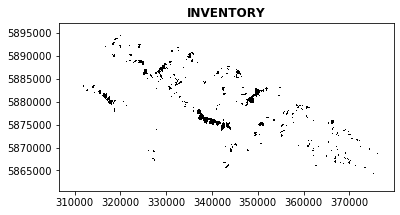

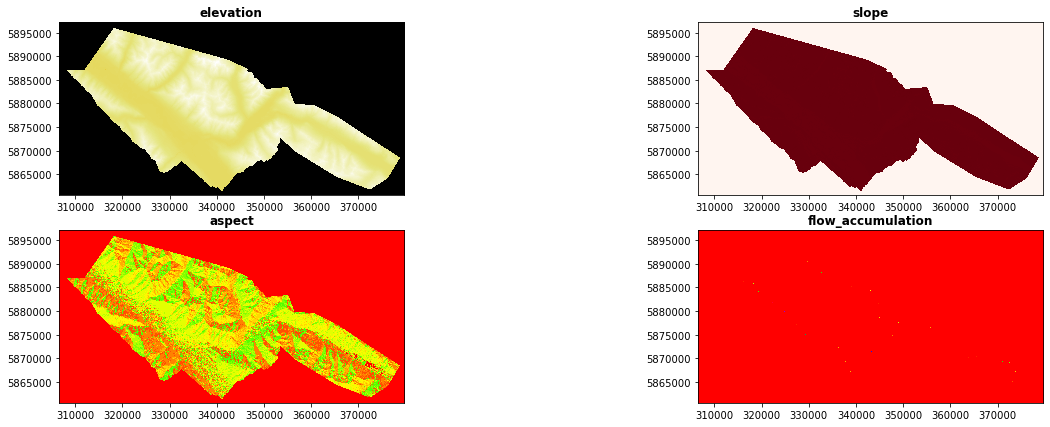

In [7]:
! cd /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/
import rasterio
from rasterio import *
from rasterio.plot import show
from matplotlib import pyplot
inventory = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/inventory_def.tif")
rasterio.plot.show(inventory, title='INVENTORY', cmap="binary")

fig, ((ax1, ax2),(ax3, ax4))= pyplot.subplots(2,2, figsize=(21,7))
map1 = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation.tif")
show((map1, 1), ax=ax1, title='elevation', cmap="CMRmap")
map2 = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/slope.tif")
show((map2, 1), ax=ax2, title='slope', cmap="Reds")
map3 = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/aspect.tif")
show((map3, 1), ax=ax3, title='aspect', cmap="prism")
map4 = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/flow_acc.tif")
show((map4, 1), ax=ax4, title='flow_accumulation', cmap="prism")
pyplot.show()


### 2.4- EXTRACT THE DATA TABLE FROM RASTER LAYERS

The objective of this section is to organize the data in a tabular format in a way that: 
* Each row corresponds to one single pixel observation 
* Each column corresponds to the value that contains each raster map in the same pixel, i.e, the variables. 

In [ ]:
%%bash
cd /home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/
# generate a virtual multiband layer with all the raster maps
gdalbuildvrt -separate variables_stack_2.vrt inventory_def.tif elevation.tif slope.tif aspect.tif flow_acc.tif 
gdalinfo variables_stack_2.vrt | tail -23
echo ""
echo ""
# generate the xyz table skipinig nodata pixels
gdal2xyz.py -allbands -skipnodata variables_stack_2.vrt /home/txomin/LVM_shared/Project/Valemount_data/valemount_source_dataset_2.txt
#head -20 /home/txomin/LVM_shared/Project/Valemount_data/valemount_source_dataset_2.txt


In [9]:
%%bash
head -20 /home/txomin/LVM_shared/Project/Valemount_data/valemount_source_dataset_2.txt

318111.460 5895928.235 0 2149.23 -9999 -9999 6
318116.460 5895928.235 0 2151.8 -9999 -9999 6
318121.460 5895928.235 0 2153.36 -9999 -9999 1
318126.460 5895928.235 0 2154.47 -9999 -9999 1
318106.460 5895923.235 0 2148 -9999 -9999 742
318111.460 5895923.235 0 2151.51 -9999 -9999 9
318116.460 5895923.235 0 2154.06 33.5292 318.359 5
318121.460 5895923.235 0 2155.99 31.6916 328.32 5
318126.460 5895923.235 0 2157.46 -9999 -9999 1
318131.460 5895923.235 0 2158.57 -9999 -9999 10
318136.460 5895923.235 0 2159.91 -9999 -9999 6
318141.460 5895923.235 0 2161.81 -9999 -9999 6
318146.460 5895923.235 0 2163.8 -9999 -9999 1
318151.460 5895923.235 0 2165.67 -9999 -9999 1
318106.460 5895918.235 0 2150.79 -9999 -9999 43
318111.460 5895918.235 0 2154.07 37.8872 310.268 741
318116.460 5895918.235 0 2156.66 34.1429 317.984 8
318121.460 5895918.235 0 2158.6 31.4858 325.843 4
318126.460 5895918.235 0 2160.15 30.3317 331.319 4
318131.460 5895918.235 0 2161.48 30.7167 333.778 4


## **3.0 Data Exploration**

Once we have our information well organized in a table, let's explore and refine it.

In [1]:
from IPython.display import Image
import rasterio
from rasterio import *
from rasterio.plot import show
from rasterio.plot import show_hist
from sklearn.preprocessing import MinMaxScaler
import geopandas
import pandas as pd
from matplotlib import pyplot
#import skgstat as skg  # It gives AttributeError: module 'plotly.graph_objs' has no attribute 'FigureWidget'
import numpy as np
import seaborn as sns

In [3]:
original_data_table = pd.read_csv("/home/txomin/LVM_shared/Project/Valemount_data/valemount_source_dataset_2.txt", sep=" ",  index_col=False)
original_data_table.columns = ["X", "Y", "source", "elevation", "slope", "aspect", "flow_acc"]
pd.set_option('display.max_columns',None)
original_data_table.head(10)

X            Y  source  elevation      slope    aspect  flow_acc
0  318116.46  5895928.235       0    2151.80 -9999.0000 -9999.000       6.0
1  318121.46  5895928.235       0    2153.36 -9999.0000 -9999.000       1.0
2  318126.46  5895928.235       0    2154.47 -9999.0000 -9999.000       1.0
3  318106.46  5895923.235       0    2148.00 -9999.0000 -9999.000     742.0
4  318111.46  5895923.235       0    2151.51 -9999.0000 -9999.000       9.0
5  318116.46  5895923.235       0    2154.06    33.5292   318.359       5.0
6  318121.46  5895923.235       0    2155.99    31.6916   328.320       5.0
7  318126.46  5895923.235       0    2157.46 -9999.0000 -9999.000       1.0
8  318131.46  5895923.235       0    2158.57 -9999.0000 -9999.000      10.0
9  318136.46  5895923.235       0    2159.91 -9999.0000 -9999.000       6.0

All the rows with NoData values (-9999) are going to be excluded from the dataset. 

In [4]:
print("original_data_table  ", original_data_table.shape)
clean_data_table = original_data_table.loc[(original_data_table["aspect"]!=-9999) & (original_data_table["source"]!=-9999)]
print("clean_data_table  ", clean_data_table.shape)
clean_data_table.head(10)

original_data_table   (46517746, 7)
clean_data_table   (39357034, 7)


X            Y  source  elevation    slope   aspect  flow_acc
5   318116.46  5895923.235       0    2154.06  33.5292  318.359       5.0
6   318121.46  5895923.235       0    2155.99  31.6916  328.320       5.0
14  318111.46  5895918.235       0    2154.07  37.8872  310.268     741.0
15  318116.46  5895918.235       0    2156.66  34.1429  317.984       8.0
16  318121.46  5895918.235       0    2158.60  31.4858  325.843       4.0
17  318126.46  5895918.235       0    2160.15  30.3317  331.319       4.0
18  318131.46  5895918.235       0    2161.48  30.7167  333.778       4.0
19  318136.46  5895918.235       0    2162.71  31.3158  331.904       5.0
20  318141.46  5895918.235       0    2164.15  30.2020  328.198       5.0
21  318146.46  5895918.235       0    2165.63  27.7112  323.888       5.0

We verify that there are no extrange values 

In [13]:
clean_data_table.loc[:, ~clean_data_table.columns.isin(['X', 'Y'])].describe()

source     elevation         slope        aspect      flow_acc
count  3.935703e+07  3.935703e+07  3.935703e+07  3.935703e+07  3.935703e+07
mean   4.226281e-02  1.588436e+03  2.620067e+01  1.750631e+02  2.457294e+03
std    2.011881e-01  4.517979e+02  1.206892e+01  1.037492e+02  1.529432e+05
min    0.000000e+00  7.330930e+02  4.945590e-04  0.000000e+00  1.000000e+00
25%    0.000000e+00  1.188990e+03  1.773670e+01  7.559980e+01  3.000000e+00
50%    0.000000e+00  1.604960e+03  2.682900e+01  1.868490e+02  1.000000e+01
75%    0.000000e+00  1.966760e+03  3.413430e+01  2.566960e+02  3.000000e+01
max    1.000000e+00  2.845970e+03  8.715910e+01  3.599990e+02  2.062980e+07

Count observations with source = 1 vs source = 0

In [14]:
print("Source area observations:      ", (clean_data_table["source"] == 1).sum())
print("Non-Source area observations:  ", (clean_data_table["source"] == 0).sum())

Source area observations:       1663339
Non-Source area observations:   37693695


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9cdc42ca0>,
      dtype=object)

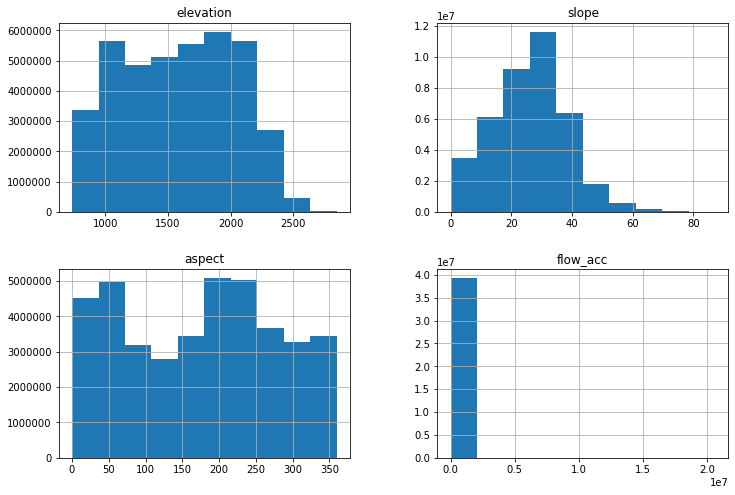

In [15]:
clean_data_table.loc[:, ~clean_data_table.columns.isin(['X', 'Y', 'source'])].hist(figsize=(12, 8))
#clean_data_table.loc[:, ~clean_data_table.columns.isin(['X', 'Y', 'source'])].boxplot(figsize=(12, 8))

In [16]:
print("flow_acc > 20000000:      ", (clean_data_table["flow_acc"] > 20000000).sum())
print("flow_acc > 10000000:      ", (clean_data_table["flow_acc"] > 10000000).sum())
print("flow_acc > 5000000:      ", (clean_data_table["flow_acc"] > 5000000).sum())
print("flow_acc > 2500000:      ", (clean_data_table["flow_acc"] > 2500000).sum())
print("flow_acc > 1000000:      ", (clean_data_table["flow_acc"] > 1000000).sum())

flow_acc > 20000000:       550
flow_acc > 10000000:       1677
flow_acc > 5000000:       5497
flow_acc > 2500000:       7933
flow_acc > 1000000:       11605


In the following code blocks we are going to normaliza the values of the explanatory variables

In [5]:
features = clean_data_table.loc[:, ~clean_data_table.columns.isin(['X', 'Y', 'source'])]
cols = clean_data_table.iloc[:,[3,4,5,6]].columns.values
print(cols)
features

['elevation' 'slope' 'aspect' 'flow_acc']


elevation     slope    aspect  flow_acc
5           2154.06  33.52920  318.3590       5.0
6           2155.99  31.69160  328.3200       5.0
14          2154.07  37.88720  310.2680     741.0
15          2156.66  34.14290  317.9840       8.0
16          2158.60  31.48580  325.8430       4.0
...             ...       ...       ...       ...
46512529    2040.47   8.61856  354.3010       1.0
46512530    2039.94  14.53420   31.1026       1.0
46512531    2039.16  18.42540   38.7273       1.0
46512532    2037.82  23.45520   52.2631       1.0
46512533    2035.73  25.49600   52.1357       1.0

[39357034 rows x 4 columns]

In [6]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
type(scaled_features)

numpy.ndarray

In [19]:
scaled_features.shape

(39357034, 4)

In [20]:
data_3 = clean_data_table.iloc[:,:3]
data_3.shape

(39357034, 3)

In [21]:
cols

array(['elevation', 'slope', 'aspect', 'flow_acc'], dtype=object)

In [7]:
data_scaled = clean_data_table.iloc[:,:3]
data_scaled[["elevation", "slope", "aspect", "flow_acc"]] = scaled_features
data_scaled

X            Y  source  elevation     slope    aspect  \
5         318116.46  5895923.235       0   0.672527  0.384686  0.884333   
6         318121.46  5895923.235       0   0.673441  0.363603  0.912003   
14        318111.46  5895918.235       0   0.672532  0.434687  0.861858   
15        318116.46  5895918.235       0   0.673758  0.391727  0.883291   
16        318121.46  5895918.235       0   0.674676  0.361242  0.905122   
...             ...          ...     ...        ...       ...       ...   
46512529  372166.46  5861728.235       0   0.618766  0.098878  0.984172   
46512530  372171.46  5861728.235       0   0.618515  0.166750  0.086396   
46512531  372176.46  5861728.235       0   0.618146  0.211395  0.107576   
46512532  372181.46  5861728.235       0   0.617512  0.269104  0.145176   
46512533  372186.46  5861728.235       0   0.616523  0.292519  0.144822   

              flow_acc  
5         1.938943e-07  
6         1.938943e-07  
14        3.587044e-05  
15        3.393150e-07  
16        1.454207e-07  
...                ...  
46512529  0.000000e+00  
46512530  0.000000e+00  
46512531  0.000000e+00  
46512532  0.000000e+00  
46512533  0.000000e+00  

[39357034 rows x 7 columns]

Now we are going to create a sample of the dataset where the amount of 0 and 1 is balanced.

In [8]:
idx_1 = data_scaled.index[data_scaled["source"]==1].tolist()
idx_0 = data_scaled.index[data_scaled["source"]==0].tolist()
idx_0 = np.random.choice(idx_0,len(idx_1),replace=False)
print(len(idx_1))
print(idx_1[:10])
print(len(idx_0))
print(idx_0[:10])
idx = np.concatenate((idx_1,idx_0))


1663339
[150961, 150962, 150963, 150964, 150965, 150966, 152101, 152102, 152103, 152104]
1663339
[26688694 45123329  9564539 10816655  5537332 13037328  5980513 23094458
 18879536 30389180]


In [9]:
balanced_data = data_scaled.loc[idx]
balanced_data

X            Y  source  elevation     slope    aspect  \
150961    319961.46  5894608.235       1   0.595940  0.339840  0.396357   
150962    319966.46  5894608.235       1   0.595272  0.362591  0.450573   
150963    319971.46  5894608.235       1   0.595045  0.400068  0.502524   
150964    319976.46  5894608.235       1   0.595320  0.440486  0.538529   
150965    319981.46  5894608.235       1   0.595973  0.468536  0.550835   
...             ...          ...     ...        ...       ...       ...   
27886027  339506.46  5874793.235       0   0.386765  0.131417  0.613079   
41033936  340421.46  5868053.235       0   0.050412  0.194976  0.622460   
9066271   329916.46  5885468.235       0   0.116418  0.275109  0.405784   
33465275  322626.46  5872008.235       0   0.326563  0.358624  0.738435   
42614980  371521.46  5867053.235       0   0.223045  0.242978  0.039239   

              flow_acc  
150961    9.694714e-08  
150962    4.362621e-07  
150963    1.938943e-07  
150964    2.423678e-07  
150965    1.938943e-07  
...                ...  
27886027  6.204617e-06  
41033936  5.332093e-07  
9066271   1.454207e-07  
33465275  9.694714e-08  
42614980  2.908414e-07  

[3326678 rows x 7 columns]

Finaly we generate the scatter plots to observe the relationship between the variables. 

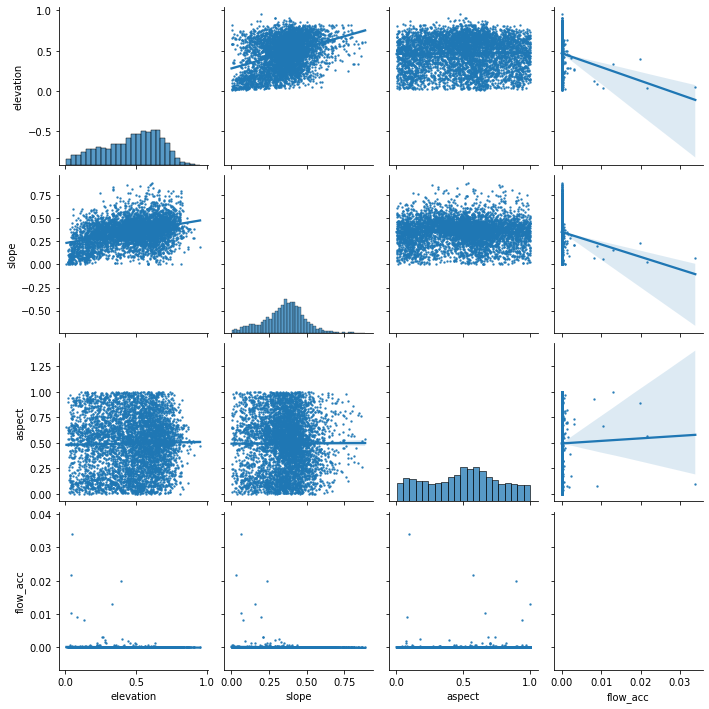

In [25]:
predictors_sample = balanced_data.loc[:, ~balanced_data.columns.isin(['X', 'Y', 'source'])].sample(5000)
sns.pairplot(predictors_sample ,  kind="reg", plot_kws=dict(scatter_kws=dict(s=2)))  
pyplot.show()

**I'd like to do a variogram to check the spatial autorcorrelation but cant install skgstat**

## **4.0 Machine Learning**

In [26]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### 4.1 Data set splitting

Split the dataset (balanced_data) in order to create response variable vs predictors variables.
 

In [27]:
print(f"Number observations with 1:  {balanced_data.loc[balanced_data['source']==1].shape}")
print(f"Number observations with 0:  {balanced_data.loc[balanced_data['source']==0].shape}")
#print("Test data set")
#print(f"number of pixels with value 1: {np.count_nonzero(Y_test == 1)}")
#print(f"number of pixels with value 0: {np.count_nonzero(Y_test == 0)}")

Number observations with 1:  (1663339, 7)
Number observations with 0:  (1663339, 7)


I create a subset for the exploration phase

In [28]:
subset = balanced_data[::10]
print(subset.shape)
#print(subset["source"].unique)
print("")
print(f"Number observations with 1:  {subset.loc[subset['source']==1].shape}")
print(f"Number observations with 0:  {subset.loc[subset['source']==0].shape}")

(332668, 7)

Number observations with 1:  (166334, 7)
Number observations with 0:  (166334, 7)


We separate the predictors in an independent dataframe

In [29]:
#predictors = balanced_data.iloc[:,[3,4,5,6,7,8]]
#predictors = subset.iloc[:,[3,4,5,6,7,8]]
predictors = subset.iloc[:,[3,4,5,6]]
predictors.head()

elevation     slope    aspect      flow_acc
150961   0.595940  0.339840  0.396357  9.694714e-08
152105   0.593540  0.432921  0.523760  2.908414e-07
153248   0.592641  0.384547  0.392640  1.938943e-07
153258   0.592565  0.412114  0.568174  4.847357e-08
154403   0.590492  0.485489  0.506679  2.423678e-07

And we generate the target variable Y.

In [30]:
#Y = balanced_data.iloc[:,2].values
Y = subset.iloc[:,2].values
#cols = balanced_data.iloc[:,[3,4,5,6,7,8]].columns.values
cols = subset.iloc[:,[3,4,5,6]].columns.values

In [32]:
Y.shape

(332668,)

In [33]:
np.unique(Y)

array([0, 1])

In [34]:
class_sample_count = np.array(
    [len(np.where(Y == t)[0]) for t in np.unique(Y)])

In [35]:
print(class_sample_count)

[166334 166334]


Create 4 dataset for training and testing the algorithms

In [36]:
predictors_train, predictors_test, Y_train, Y_test = train_test_split(predictors, Y, test_size=0.3, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)
predictors_train

elevation     slope    aspect      flow_acc
4543580    0.489895  0.416931  0.090972  2.423678e-07
31626453   0.623329  0.452705  0.609088  4.459568e-06
8014862    0.500084  0.343213  0.370626  7.271035e-07
12333889   0.351926  0.308792  0.002270  9.694714e-08
1119096    0.400774  0.096089  0.546268  1.216687e-05
...             ...       ...       ...           ...
27937440   0.293026  0.271926  0.815419  1.420276e-05
13744240   0.237982  0.517935  0.433001  3.829412e-06
23266746   0.111182  0.117781  0.669988  4.847357e-08
460383     0.643240  0.338554  0.273997  1.163366e-06
10976443   0.665390  0.200948  0.046691  0.000000e+00

[232867 rows x 4 columns]

Verify that in both thaining and testing datasets the number of 0 and 1 is balanced.

In [37]:
np.unique(Y_test)
print("Train data set")
print(f"number of pixels with value 1: {np.count_nonzero(Y_train == 1)}")
print(f"number of pixels with value 0: {np.count_nonzero(Y_train == 0)}")

Train data set
number of pixels with value 1: 116366
number of pixels with value 0: 116501


In [38]:
np.unique(Y_test)
print("Test data set")
print(f"number of pixels with value 1: {np.count_nonzero(Y_test == 1)}")
print(f"number of pixels with value 0: {np.count_nonzero(Y_test == 0)}")

Test data set
number of pixels with value 1: 49968
number of pixels with value 0: 49833


### 4.2 Random Forest
We want to generate a RF algorithm to predict the probability of being a debris flow source area.

Even though we are in a classification problem. We are going to use the **Regression** mode of the Random Forest. 

First we are going to evaluating the optimal n_estimator value for the Random Forest

In [ ]:
scores =[]
for k in range(20, 100):
    rfReg = RandomForestClassifier(n_estimators=k,max_features=0..33,max_depth=150,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True)
    rfReg.fit(predictors_train, y_train);
    dic_pred['test'] = rfReg.predict(predictors_test)
    scores.append(metrics.accuracy_score(y_test, dic_pred['test']))
    
%matplotlib inline
plt.plot(range(20, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Prediction Accuracy')    
    
    

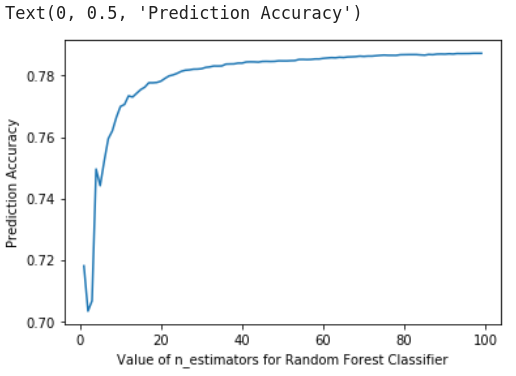

In [39]:
Image("/home/txomin/LVM_shared/Project/Figures/RF_optimization.png" , width = 500, height = 300)

**The model exploration phase gave the following conclusions:**

* n_estimators = 30 is the optimal parameter
Let's now run the final model 


In [40]:
rfReg = RandomForestRegressor(n_estimators=30,max_features=0.33,max_depth=150,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True)
rfReg.fit(predictors_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(predictors_train)
dic_pred['test'] = rfReg.predict(predictors_test)

In [41]:
dic_pred

{'train': array([0.3780577 , 0.80381591, 0.747023  , ..., 0.02925411, 0.60093102,
        0.05171677]),
 'test': array([0.50321099, 0.02264603, 0.71128009, ..., 0.68730963, 0.77844419,
        0.64082765])}

We generate a confusion matrix and a ROC curve in order to evaluate the performance of the model.

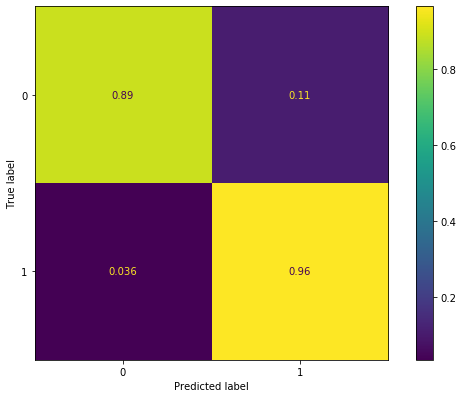

In [42]:
y_pred = (dic_pred['train'] > 0.5).astype('float')
cm = confusion_matrix(y_train, y_pred, normalize = "true")
cm_display = ConfusionMatrixDisplay(cm).plot()

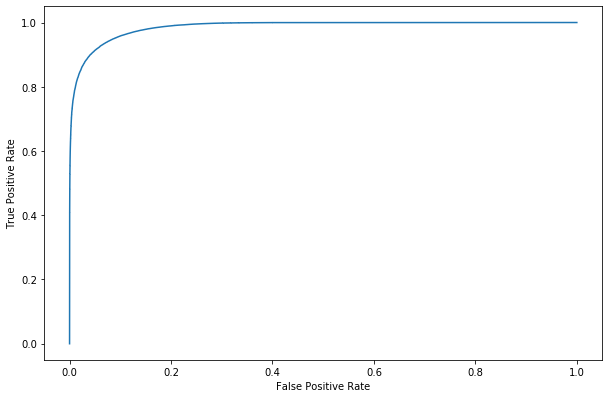

In [43]:
#y_score = rfReg.decision_function(predictors_test)
fpr, tpr, _ = roc_curve(y_train,dic_pred['train'], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

We can explore the organization of the results using the scatterplot.

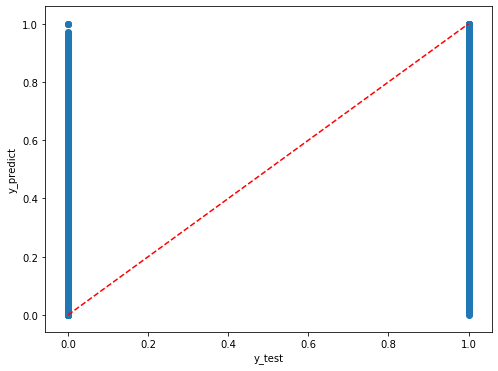

In [44]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
#plt.scatter(y_train,y_pred)
plt.xlabel('y_test')
plt.ylabel('y_predict')
ident = [0, 1]
plt.plot(ident,ident,'r--')

We can also have a look to the relevance of the used variables.

In [45]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

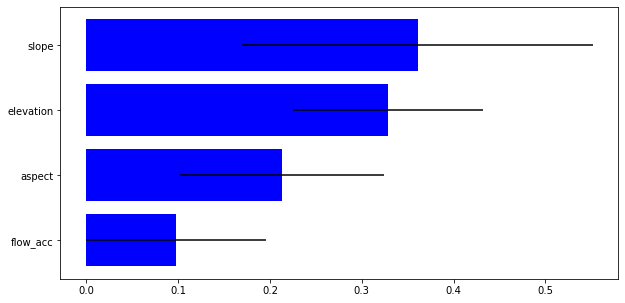

In [46]:
cols = clean_data_table.iloc[:,[3,4,5,6]].columns.values
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(range(len(cols)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(cols)),cols[ind]);

**Now we can apply the generated model to the raster maps and obtain a susceptibility map**

In [ ]:
elevation = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation.tif")
slope = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/slope.tif")
aspect = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/aspect.tif")
flow_acc = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/flow_acc.tif")

In [ ]:
predictors_rasters = [elevation, slope, aspect, flow_acc]

stack = Raster(predictors_rasters)

In [ ]:
result = stack.predict(estimator=rfReg, dtype='float64', nodata=-9999)
#result_proba = stack.predict_proba(estimator=rfReg, dtype='float32', nodata=-9999)

In [ ]:
result.count

In [ ]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

In [ ]:
result.write('/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/source_prob.tif')

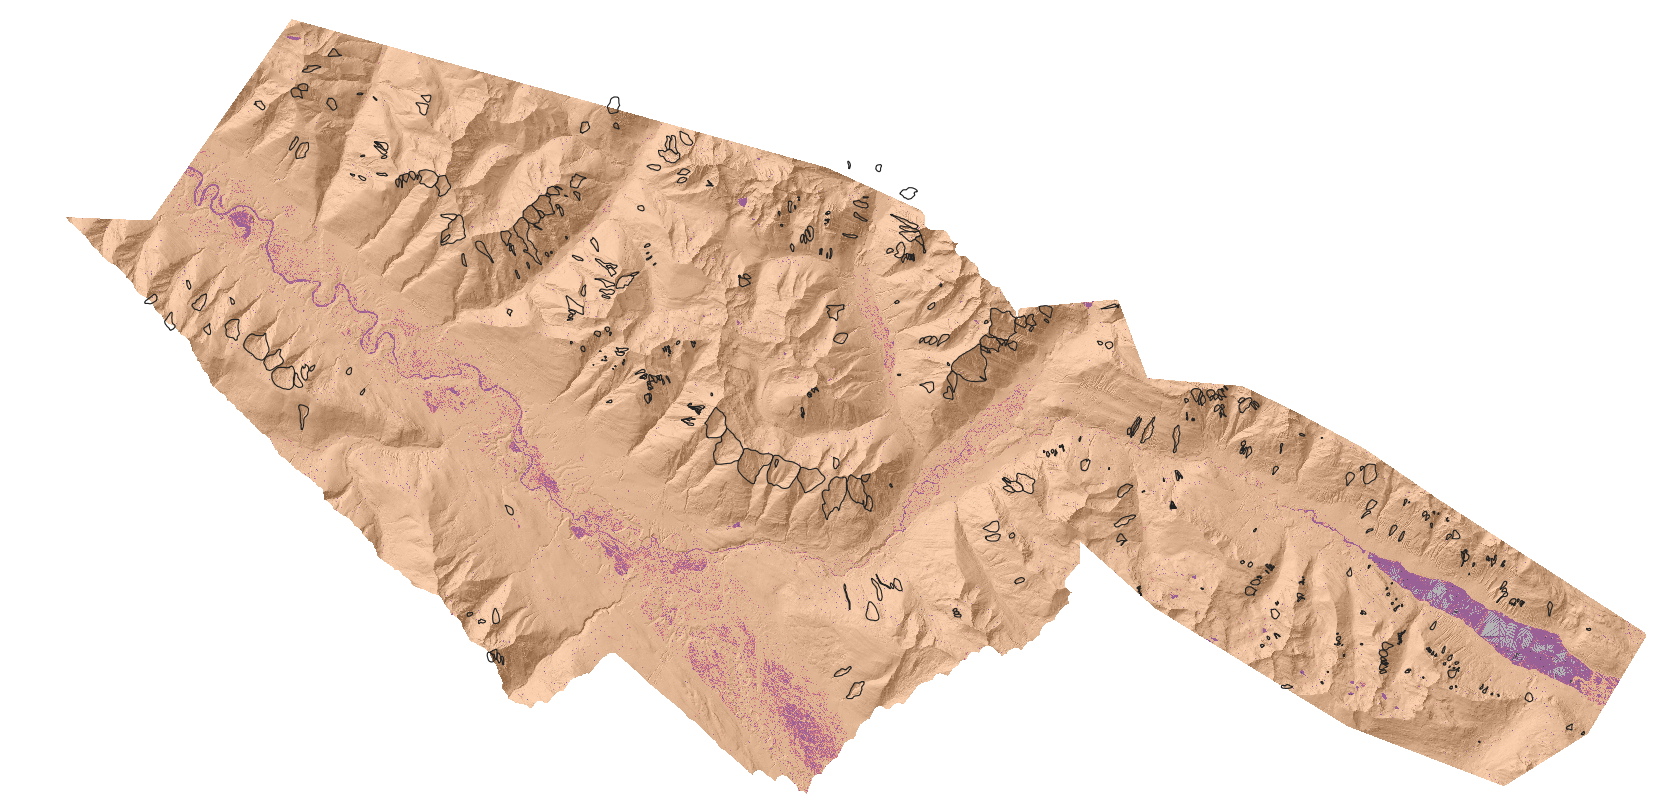

In [47]:
from IPython.display import Image
Image("/home/txomin/LVM_shared/Project/Figures/RfRegressor_map.png" , width = 800, height = 500)

### 4.3 Support Vector Machine for Regression (SVR)

We are going to try to apply the SVM Regressor to the same dataset. 

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

We can plot a scatter plot of the most potential variables [elevation and slope] to observe if there is a clustering.

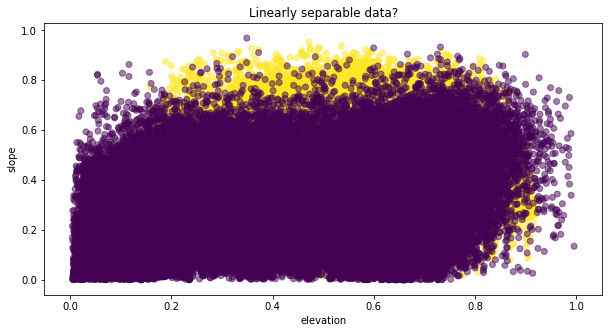

In [49]:
plt.scatter(subset["elevation"], subset["slope"],c=subset["source"],alpha=0.5)
plt.title('Linearly separable data?')
plt.xlabel('elevation')
plt.ylabel('slope')
plt.show()

We create a much smaller subset for the exploration phase in order to avoid very long computational time.

In [11]:
subset_100 = balanced_data[::100]
print(subset_100.shape)
#print(subset["source"].unique)
print("")
print(f"Number observations with 1:  {subset_100.loc[subset_100['source']==1].shape}")
print(f"Number observations with 0:  {subset_100.loc[subset_100['source']==0].shape}")

(33267, 7)

Number observations with 1:  (16634, 7)
Number observations with 0:  (16633, 7)


We can save the subset table to use it directly in case of computer crash, and avoid all the previous steps. 

In [12]:
subset_100.to_csv("/home/txomin/LVM_shared/Project/Valemount_data/subset_100.txt", header="True", sep=' ', mode='a')
#subset_100.write("/home/txomin/LVM_shared/Project/Valemount_data/subset_100.txt")#

In [ ]:
table = pd.read_csv("/home/txomin/LVM_shared/Project/Valemount_data/subset_100.txt", sep=" ",  index_col=False)
table.head()

So, we have to split the data again in training and test subsets

In [13]:
#predictors = balanced_data.iloc[:,[3,4,5,6,7,8]]
#predictors = subset.iloc[:,[3,4,5,6,7,8]]
predictors = subset_100.iloc[:,[3,4,5,6]]
predictors.head()

elevation     slope    aspect      flow_acc
150961   0.595940  0.339840  0.396357  9.694714e-08
157876   0.584775  0.405498  0.448568  3.393150e-07
162557   0.588556  0.386079  0.216777  5.332093e-07
166125   0.576947  0.519611  0.280226  1.502681e-06
169719   0.594458  0.375756  0.173641  0.000000e+00

In [14]:
#Y = balanced_data.iloc[:,2].values
Y = subset_100.iloc[:,2].values
#cols = balanced_data.iloc[:,[3,4,5,6,7,8]].columns.values
cols = subset_100.iloc[:,[3,4,5,6]].columns.values

In [15]:
predictors_train, predictors_test, Y_train, Y_test = train_test_split(predictors, Y, test_size=0.3, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)
predictors_train

elevation     slope    aspect      flow_acc
23310647   0.069639  0.157875  0.646518  1.454207e-07
11105549   0.680895  0.449267  0.775413  1.017945e-06
25188622   0.538591  0.373464  0.739144  5.332093e-07
16704940   0.645838  0.552962  0.479199  9.209978e-07
17419574   0.476822  0.447592  0.485196  5.816828e-07
...             ...       ...       ...           ...
15256488   0.655266  0.781469  0.503718  1.454207e-07
15886672   0.536405  0.397595  0.151926  1.017945e-06
11527887   0.420302  0.407068  0.675394  4.847357e-08
30547721   0.544867  0.266243  0.684146  5.816828e-07
2970286    0.569260  0.714146  0.611796  7.755771e-07

[23286 rows x 4 columns]

In [55]:
print(predictors_train.shape)
print(y_train.shape)

(23286, 4)
(23286,)


We can explore the optimal Regularization value.

In [16]:
for n in np.arange(1,11):
    svr = SVR(C=n, kernel="rbf")
    svr.fit(predictors_train, y_train) # Fit the SVR model according to the given training data.
    print(f"Regularization C = {n} and kernel = rbf")
    print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(predictors_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
    print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(predictors_test, y_test)))
    print("")

Regularization C = 1 and kernel = rbf
Accuracy of SVR on training set: 0.24024
Accuracy of SVR on test set: 0.24185

Regularization C = 2 and kernel = rbf
Accuracy of SVR on training set: 0.24128
Accuracy of SVR on test set: 0.24294

Regularization C = 3 and kernel = rbf
Accuracy of SVR on training set: 0.24102
Accuracy of SVR on test set: 0.24268

Regularization C = 4 and kernel = rbf
Accuracy of SVR on training set: 0.24143
Accuracy of SVR on test set: 0.24291

Regularization C = 5 and kernel = rbf
Accuracy of SVR on training set: 0.24151
Accuracy of SVR on test set: 0.24282

Regularization C = 6 and kernel = rbf
Accuracy of SVR on training set: 0.24164
Accuracy of SVR on test set: 0.24309

Regularization C = 7 and kernel = rbf
Accuracy of SVR on training set: 0.24169
Accuracy of SVR on test set: 0.24309

Regularization C = 8 and kernel = rbf
Accuracy of SVR on training set: 0.24158
Accuracy of SVR on test set: 0.24296

Regularization C = 9 and kernel = rbf
Accuracy of SVR on trainin

In [56]:
svr = SVR(C=4, kernel="rbf")
svr.fit(predictors_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(predictors_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(predictors_test, y_test)))

Accuracy of SVR on training set: 0.24744
Accuracy of SVR on test set: 0.23693


In [57]:
svr_pred = {}
svr_pred['train'] = svr.predict(predictors_train)
svr_pred['test'] = svr.predict(predictors_test)

In [58]:
print(f"range prediction train: {np.min(svr_pred['train'])} --  {np.max(svr_pred['train'])}")
print(f"range prediction test: {np.min(svr_pred['test'])} --  {np.max(svr_pred['test'])}")

range prediction train: -0.6247238892601716 --  1.2884218089203205
range prediction test: -1.1966206427227377 --  1.1193402180140222


The resulting values are in the range of -1.2 and 1.3. 

In order to represent the susceptibility these values should be passed by a *SIGMOIDAL* function.

> def sig_func(x):

> return 1 / (1 + np.exp(-x))output = sig_func(input)
  
> print(output)

**The following commands block is the repetition of the block ran in the Random Forest section.**

**It is not ras because it takes a lot of time.**

In [ ]:
#del original_data_table
#del clean_data_table

In [ ]:
elevation = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/elevation.tif")
slope = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/slope.tif")
aspect = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/aspect.tif")
flow_acc = rasterio.open("/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/flow_acc.tif")

In [ ]:
predictors_rasters = [elevation, slope, aspect, flow_acc]

stack = Raster(predictors_rasters)

In [ ]:
result = stack.predict(estimator=svr, dtype='float32', nodata=-9999)
#result_proba = stack.predict_proba(estimator=rfReg, dtype='float32', nodata=-9999)

In [ ]:
result.count

In [ ]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

In [ ]:
result.write('/home/txomin/LVM_shared/Project/Valemount_data/Raster_variables/source_prob_svm.tif')

## Multilayer Perceptron (MP)



In [14]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Upload the data

In [16]:
subset_100 = pd.read_csv("/home/txomin/LVM_shared/Project/Valemount_data/subset_100.txt", sep=" ",  index_col=False)
subset_100 = subset_100.iloc[:,1:]
subset_100.head()

<ipython-input-16-d056b02f7cc8>:1: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  subset_100 = pd.read_csv("/home/txomin/LVM_shared/Project/Valemount_data/subset_100.txt", sep=" ",  index_col=False)


X            Y source           elevation                slope  \
0  319961.46  5894608.235      1  0.5959395648681869  0.33984028646546643   
1  319986.46  5894578.235      1  0.5847746934629892   0.4054976013231919   
2  319961.46  5894558.235      1  0.5885562671182469   0.3860789794735605   
3  319991.46  5894543.235      1  0.5769465046947835   0.5196114051142899   
4  319951.46  5894528.235      1  0.5944581724350257   0.3757564187183976   

                aspect               flow_acc  
0  0.39635665654626817  9.694713942680682e-08  
1   0.4485679126886464  3.393149879938239e-07  
2  0.21677699104719736  5.332092668474375e-07  
3     0.28022577840494  1.502680661115506e-06  
4  0.17364076011322255                    0.0

In [3]:
#predictors = balanced_data.iloc[:,[3,4,5,6,7,8]]
#predictors = subset.iloc[:,[3,4,5,6,7,8]]
predictors = subset_100.iloc[:,[3,4,5,6]]
predictors.head()

elevation                slope               aspect  \
0  0.5959395648681869  0.33984028646546643  0.39635665654626817   
1  0.5847746934629892   0.4054976013231919   0.4485679126886464   
2  0.5885562671182469   0.3860789794735605  0.21677699104719736   
3  0.5769465046947835   0.5196114051142899     0.28022577840494   
4  0.5944581724350257   0.3757564187183976  0.17364076011322255   

                flow_acc  
0  9.694713942680682e-08  
1  3.393149879938239e-07  
2  5.332092668474375e-07  
3  1.502680661115506e-06  
4                    0.0

In [4]:
#Y = balanced_data.iloc[:,2].values
Y = subset_100.iloc[:,2].values
#cols = balanced_data.iloc[:,[3,4,5,6,7,8]].columns.values
cols = subset_100.iloc[:,[3,4,5,6]].columns.values

In [5]:
predictors_train, predictors_test, Y_train, Y_test = train_test_split(predictors, Y, test_size=0.3, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)
predictors_train

elevation                slope               aspect  \
17990   0.11525091143497707   0.3014757442257044   0.9190747752077089   
6084    0.45213564253858607  0.41195135304574293   0.2594462762396562   
30356  0.047089347841828944   0.0844628640367968   0.5593959983222175   
48802    0.3844459473977899  0.44209180775710577   0.8939580387723299   
47361    0.4474784854963162  0.37815434602508763   0.4812041144558735   
...                     ...                  ...                  ....   
12411    0.5962614009239535  0.39583590474441815  0.44982347173186593   
6500     0.6552662554422242   0.7814685090057648   0.5037180658835163   
21633     0.649212897863908  0.17937305630231787    0.923235897877494   
59537    0.1984625702300702  0.31834958006278136   0.7250297917494215   
899       0.569260302421769   0.7141464130370311   0.6117961438781775   

                     flow_acc  
17990  4.8473569713403414e-08  
6084    9.694713942680682e-08  
30356  2.4236784856701703e-07  
48802   5.816828365608409e-07  
47361   6.301564062742443e-07  
...                       ...  
12411  2.9084141828042046e-07  
6500   1.4542070914021023e-07  
21633   3.393149879938239e-07  
59537   2.472152055383574e-06  
899     7.755771154144546e-07  

[46574 rows x 4 columns]

In [6]:
print(predictors_train.shape)
print(y_train.shape)

(46574, 4)
(46574,)


In [7]:
print("Train data set")
print(f"number of pixels with value 1: {np.count_nonzero(Y_train == 1)}")
print(f"number of pixels with value 0: {np.count_nonzero(Y_train == 0)}")

Train data set
number of pixels with value 1: 0
number of pixels with value 0: 691


In [8]:
print("Test data set")
print(f"number of pixels with value 1: {np.count_nonzero(Y_test == 1)}")
print(f"number of pixels with value 0: {np.count_nonzero(Y_test == 0)}")

Test data set
number of pixels with value 1: 0
number of pixels with value 0: 308


In order to convert the predictors data frame to the Torch data, first they have to be transformed into *numpy*.

In [12]:
type(predictors_train)

pandas.core.frame.DataFrame

In [10]:
Predictors_train = predictors_train.to_numpy()
Predictors_test = predictors_test.to_numpy()

In [13]:
type(Predictors_train)

numpy.ndarray

In [ ]:
predictors_train = torch.FloatTensor(Predictors_train)
y_train = torch.FloatTensor(y_train)
predictors_test = torch.FloatTensor(Predictors_test)
y_test = torch.FloatTensor(y_test)

The objective is to run a Feed Forward Neural Network with the following parameters:
* Mean Square Error (MSE) as a the evaluation criterion
* Stochastic Gradient Descent (SGD) as the optimizer function
* 1000 Epochs
* Dimention Ranges 5, 25, 50, 100
* Lerning Rate values 0.75, 0.5, 0.1, 0.01, 0.05, 0.001
* Two hidden layers
* Sigmoidal final activation function

In [56]:
# Try with FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.sigmoid(self.fc2(hidden))
        output = self.sigmoid(self.fc3(hidden))
        # hidden = self.relu(self.fc4(hidden))
        #output = self.sigmoid(self.fc3(hidden))

        return output


hid_dim: 5, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0655
Epoch 100, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0550
Epoch 200, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0469
Epoch 300, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0265
Epoch 400, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0578
Epoch 500, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0567
Epoch 600, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0626
Epoch 700, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0730
Epoch 800, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0885
Epoch 900, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.1086


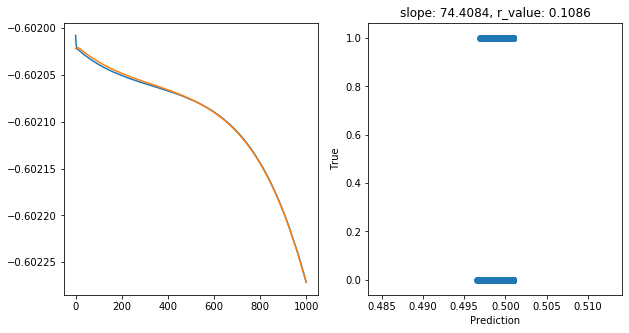

Saving model to  ./models/model_SGD_1000_lr0.75_hid_dim5

hid_dim: 5, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2619, val_loss: 0.2595, r_value: -0.0813
Epoch 100, train_loss: 0.2500, val_loss: 0.2499, r_value: 0.0514
Epoch 200, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.2299
Epoch 300, train_loss: 0.2496, val_loss: 0.2495, r_value: 0.3505
Epoch 400, train_loss: 0.2493, val_loss: 0.2492, r_value: 0.4086
Epoch 500, train_loss: 0.2488, val_loss: 0.2487, r_value: 0.4348
Epoch 600, train_loss: 0.2478, val_loss: 0.2478, r_value: 0.4476
Epoch 700, train_loss: 0.2459, val_loss: 0.2459, r_value: 0.4538
Epoch 800, train_loss: 0.2418, val_loss: 0.2417, r_value: 0.4563
Epoch 900, train_loss: 0.2334, val_loss: 0.2333, r_value: 0.4573


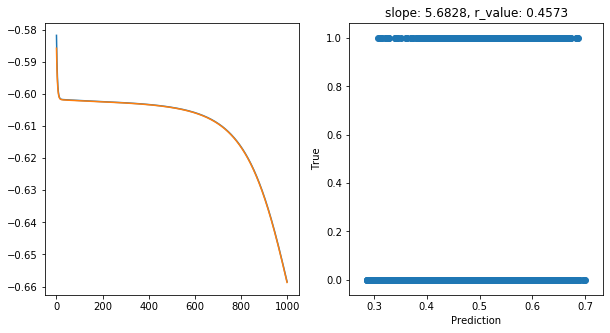

Saving model to  ./models/model_SGD_1000_lr0.5_hid_dim5

hid_dim: 5, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2509, val_loss: 0.2508, r_value: -0.2765
Epoch 100, train_loss: 0.2507, val_loss: 0.2506, r_value: -0.2542
Epoch 200, train_loss: 0.2505, val_loss: 0.2505, r_value: -0.2279
Epoch 300, train_loss: 0.2504, val_loss: 0.2504, r_value: -0.1961
Epoch 400, train_loss: 0.2503, val_loss: 0.2503, r_value: -0.1570
Epoch 500, train_loss: 0.2502, val_loss: 0.2502, r_value: -0.1084
Epoch 600, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.0482
Epoch 700, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0248
Epoch 800, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.1088
Epoch 900, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.1972


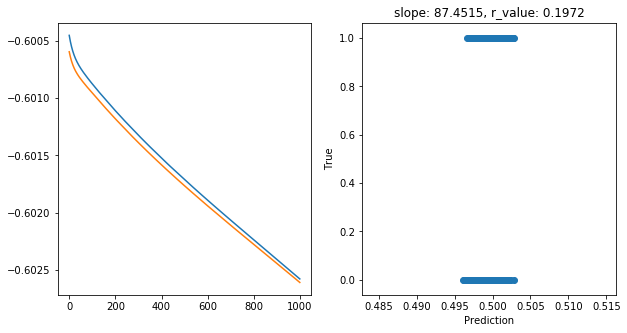

Saving model to  ./models/model_SGD_1000_lr0.1_hid_dim5

hid_dim: 5, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2356
Epoch 100, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2371
Epoch 200, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2385
Epoch 300, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2400
Epoch 400, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2414
Epoch 500, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2428
Epoch 600, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2443
Epoch 700, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2457
Epoch 800, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2471
Epoch 900, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.2486


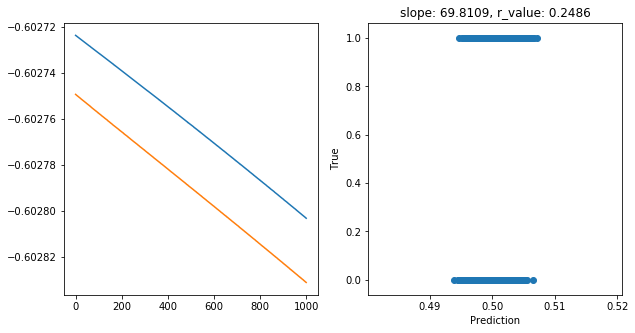

Saving model to  ./models/model_SGD_1000_lr0.01_hid_dim5

hid_dim: 5, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2759, val_loss: 0.2749, r_value: 0.3544
Epoch 100, train_loss: 0.2512, val_loss: 0.2511, r_value: 0.3689
Epoch 200, train_loss: 0.2491, val_loss: 0.2491, r_value: 0.3788
Epoch 300, train_loss: 0.2489, val_loss: 0.2489, r_value: 0.3851
Epoch 400, train_loss: 0.2488, val_loss: 0.2489, r_value: 0.3897
Epoch 500, train_loss: 0.2488, val_loss: 0.2488, r_value: 0.3932
Epoch 600, train_loss: 0.2487, val_loss: 0.2487, r_value: 0.3962
Epoch 700, train_loss: 0.2486, val_loss: 0.2486, r_value: 0.3989
Epoch 800, train_loss: 0.2485, val_loss: 0.2486, r_value: 0.4013
Epoch 900, train_loss: 0.2484, val_loss: 0.2485, r_value: 0.4035


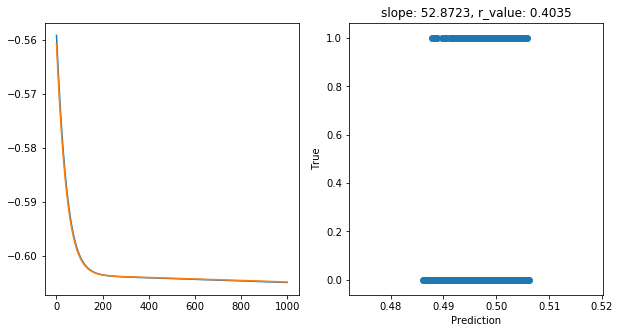

Saving model to  ./models/model_SGD_1000_lr0.05_hid_dim5

hid_dim: 5, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2577, val_loss: 0.2574, r_value: -0.0997
Epoch 100, train_loss: 0.2573, val_loss: 0.2570, r_value: -0.0989
Epoch 200, train_loss: 0.2570, val_loss: 0.2567, r_value: -0.0981
Epoch 300, train_loss: 0.2566, val_loss: 0.2563, r_value: -0.0974
Epoch 400, train_loss: 0.2563, val_loss: 0.2560, r_value: -0.0967
Epoch 500, train_loss: 0.2560, val_loss: 0.2557, r_value: -0.0960
Epoch 600, train_loss: 0.2557, val_loss: 0.2554, r_value: -0.0953
Epoch 700, train_loss: 0.2554, val_loss: 0.2551, r_value: -0.0947
Epoch 800, train_loss: 0.2551, val_loss: 0.2548, r_value: -0.0940
Epoch 900, train_loss: 0.2548, val_loss: 0.2546, r_value: -0.0934


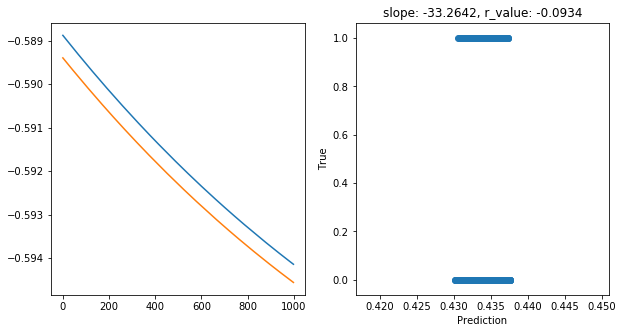

Saving model to  ./models/model_SGD_1000_lr0.001_hid_dim5

hid_dim: 25, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.2507, val_loss: 0.2501, r_value: -0.0051
Epoch 100, train_loss: 0.2493, val_loss: 0.2493, r_value: 0.3616
Epoch 200, train_loss: 0.2478, val_loss: 0.2478, r_value: 0.4514
Epoch 300, train_loss: 0.2432, val_loss: 0.2432, r_value: 0.4593
Epoch 400, train_loss: 0.2265, val_loss: 0.2265, r_value: 0.4595
Epoch 500, train_loss: 0.2008, val_loss: 0.2009, r_value: 0.4712
Epoch 600, train_loss: 0.1923, val_loss: 0.1918, r_value: 0.4889
Epoch 700, train_loss: 0.1891, val_loss: 0.1881, r_value: 0.5002
Epoch 800, train_loss: 0.1878, val_loss: 0.1865, r_value: 0.5055
Epoch 900, train_loss: 0.1872, val_loss: 0.1857, r_value: 0.5081


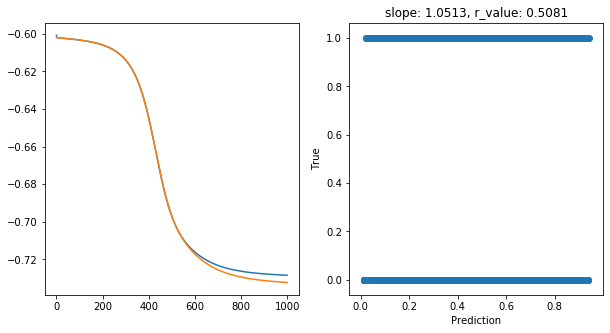

Saving model to  ./models/model_SGD_1000_lr0.75_hid_dim25

hid_dim: 25, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2522, val_loss: 0.2507, r_value: 0.0599
Epoch 100, train_loss: 0.2484, val_loss: 0.2485, r_value: 0.3156
Epoch 200, train_loss: 0.2459, val_loss: 0.2459, r_value: 0.3704
Epoch 300, train_loss: 0.2403, val_loss: 0.2403, r_value: 0.4001
Epoch 400, train_loss: 0.2279, val_loss: 0.2278, r_value: 0.4253
Epoch 500, train_loss: 0.2112, val_loss: 0.2113, r_value: 0.4469
Epoch 600, train_loss: 0.2002, val_loss: 0.2002, r_value: 0.4655
Epoch 700, train_loss: 0.1947, val_loss: 0.1944, r_value: 0.4800
Epoch 800, train_loss: 0.1916, val_loss: 0.1910, r_value: 0.4905
Epoch 900, train_loss: 0.1898, val_loss: 0.1889, r_value: 0.4972


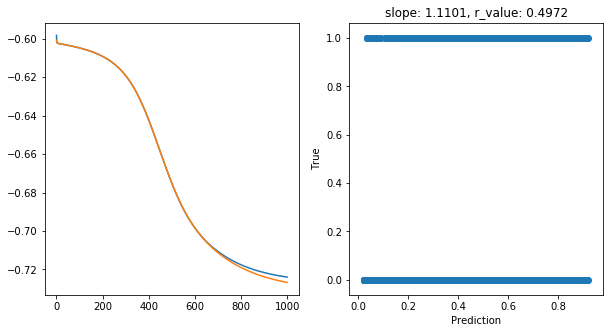

Saving model to  ./models/model_SGD_1000_lr0.5_hid_dim25

hid_dim: 25, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2612, val_loss: 0.2596, r_value: 0.0976
Epoch 100, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.1158
Epoch 200, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.2804
Epoch 300, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.3816
Epoch 400, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.4285
Epoch 500, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.4482
Epoch 600, train_loss: 0.2492, val_loss: 0.2492, r_value: 0.4562
Epoch 700, train_loss: 0.2491, val_loss: 0.2490, r_value: 0.4592
Epoch 800, train_loss: 0.2489, val_loss: 0.2489, r_value: 0.4600
Epoch 900, train_loss: 0.2487, val_loss: 0.2486, r_value: 0.4599


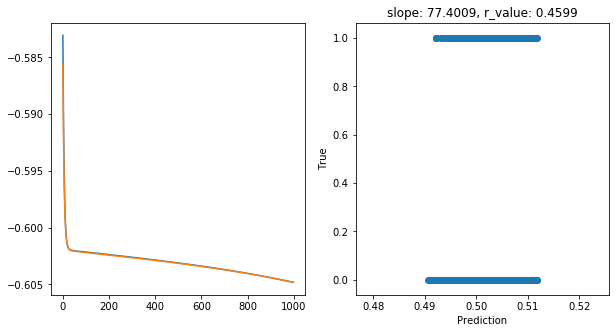

Saving model to  ./models/model_SGD_1000_lr0.1_hid_dim25

hid_dim: 25, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.4148
Epoch 100, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.4202
Epoch 200, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.4252
Epoch 300, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.4293
Epoch 400, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.4325
Epoch 500, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.4350
Epoch 600, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.4369
Epoch 700, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.4383
Epoch 800, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.4395
Epoch 900, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.4405


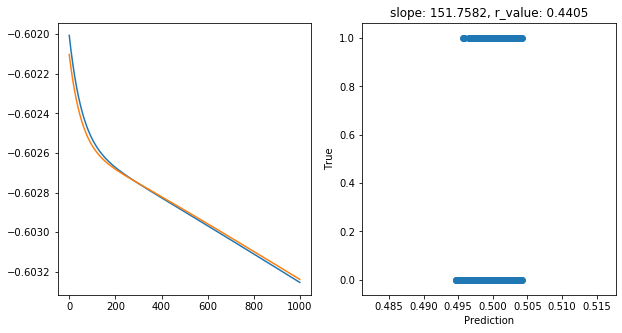

Saving model to  ./models/model_SGD_1000_lr0.01_hid_dim25

hid_dim: 25, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2612, val_loss: 0.2606, r_value: -0.0994
Epoch 100, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0553
Epoch 200, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.1630
Epoch 300, train_loss: 0.2499, val_loss: 0.2498, r_value: 0.2430
Epoch 400, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.2966
Epoch 500, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.3314
Epoch 600, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.3543
Epoch 700, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.3696
Epoch 800, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.3802
Epoch 900, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.3878


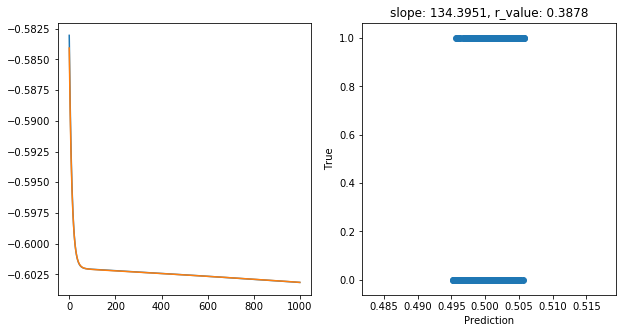

Saving model to  ./models/model_SGD_1000_lr0.05_hid_dim25

hid_dim: 25, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4030
Epoch 100, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4026
Epoch 200, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4022
Epoch 300, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4018
Epoch 400, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4014
Epoch 500, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4010
Epoch 600, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4005
Epoch 700, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.4001
Epoch 800, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.3996
Epoch 900, train_loss: 0.2507, val_loss: 0.2507, r_value: -0.3991


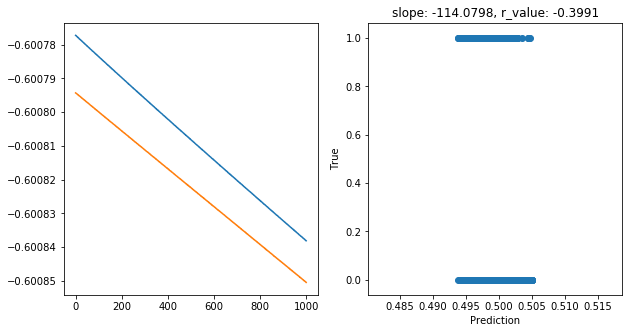

Saving model to  ./models/model_SGD_1000_lr0.001_hid_dim25

hid_dim: 50, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.2531, val_loss: 0.2504, r_value: -0.0752
Epoch 100, train_loss: 0.2469, val_loss: 0.2469, r_value: 0.4293
Epoch 200, train_loss: 0.2362, val_loss: 0.2361, r_value: 0.4556
Epoch 300, train_loss: 0.2079, val_loss: 0.2078, r_value: 0.4704
Epoch 400, train_loss: 0.1939, val_loss: 0.1934, r_value: 0.4853
Epoch 500, train_loss: 0.1902, val_loss: 0.1893, r_value: 0.4959
Epoch 600, train_loss: 0.1885, val_loss: 0.1874, r_value: 0.5021
Epoch 700, train_loss: 0.1878, val_loss: 0.1864, r_value: 0.5053
Epoch 800, train_loss: 0.1874, val_loss: 0.1859, r_value: 0.5072
Epoch 900, train_loss: 0.1871, val_loss: 0.1855, r_value: 0.5084


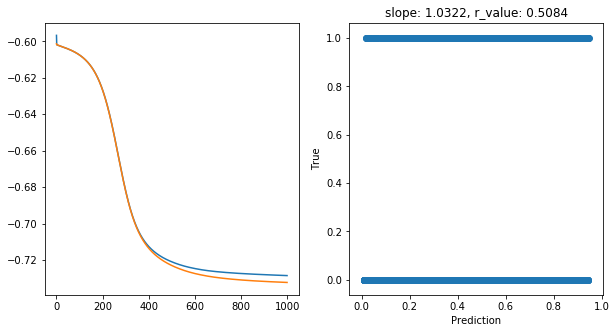

Saving model to  ./models/model_SGD_1000_lr0.75_hid_dim50

hid_dim: 50, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2646, val_loss: 0.2505, r_value: 0.1006
Epoch 100, train_loss: 0.2486, val_loss: 0.2486, r_value: 0.3606
Epoch 200, train_loss: 0.2462, val_loss: 0.2462, r_value: 0.3978
Epoch 300, train_loss: 0.2404, val_loss: 0.2405, r_value: 0.4165
Epoch 400, train_loss: 0.2270, val_loss: 0.2273, r_value: 0.4324
Epoch 500, train_loss: 0.2092, val_loss: 0.2096, r_value: 0.4482
Epoch 600, train_loss: 0.1990, val_loss: 0.1992, r_value: 0.4651
Epoch 700, train_loss: 0.1941, val_loss: 0.1939, r_value: 0.4801
Epoch 800, train_loss: 0.1913, val_loss: 0.1906, r_value: 0.4911
Epoch 900, train_loss: 0.1895, val_loss: 0.1885, r_value: 0.4982


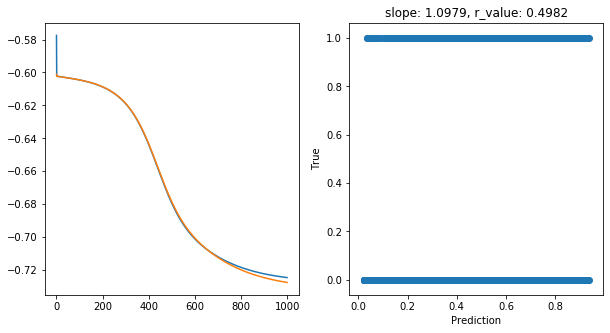

Saving model to  ./models/model_SGD_1000_lr0.5_hid_dim50

hid_dim: 50, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2510, val_loss: 0.2507, r_value: -0.0797
Epoch 100, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.1198
Epoch 200, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.2430
Epoch 300, train_loss: 0.2492, val_loss: 0.2492, r_value: 0.3108
Epoch 400, train_loss: 0.2489, val_loss: 0.2489, r_value: 0.3480
Epoch 500, train_loss: 0.2485, val_loss: 0.2485, r_value: 0.3698
Epoch 600, train_loss: 0.2481, val_loss: 0.2481, r_value: 0.3834
Epoch 700, train_loss: 0.2477, val_loss: 0.2477, r_value: 0.3926
Epoch 800, train_loss: 0.2471, val_loss: 0.2472, r_value: 0.3991
Epoch 900, train_loss: 0.2465, val_loss: 0.2466, r_value: 0.4042


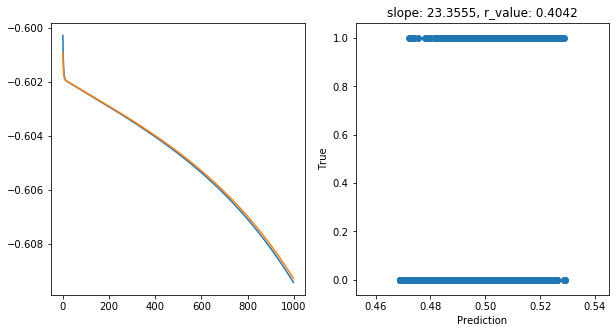

Saving model to  ./models/model_SGD_1000_lr0.1_hid_dim50

hid_dim: 50, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2583, val_loss: 0.2578, r_value: -0.2941
Epoch 100, train_loss: 0.2507, val_loss: 0.2506, r_value: -0.2481
Epoch 200, train_loss: 0.2504, val_loss: 0.2503, r_value: -0.2167
Epoch 300, train_loss: 0.2503, val_loss: 0.2503, r_value: -0.1844
Epoch 400, train_loss: 0.2502, val_loss: 0.2502, r_value: -0.1480
Epoch 500, train_loss: 0.2502, val_loss: 0.2501, r_value: -0.1065
Epoch 600, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.0603
Epoch 700, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0100
Epoch 800, train_loss: 0.2500, val_loss: 0.2500, r_value: 0.0430
Epoch 900, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.0967


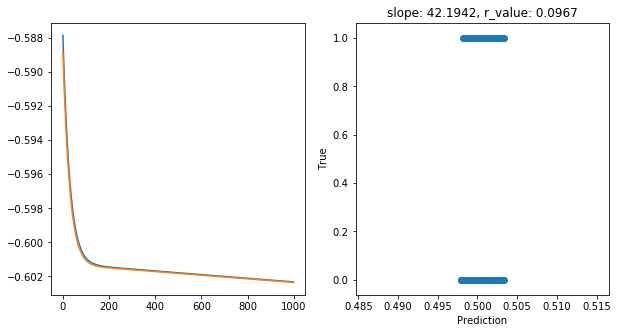

Saving model to  ./models/model_SGD_1000_lr0.01_hid_dim50

hid_dim: 50, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2601, val_loss: 0.2584, r_value: -0.1342
Epoch 100, train_loss: 0.2499, val_loss: 0.2500, r_value: 0.1041
Epoch 200, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.3417
Epoch 300, train_loss: 0.2495, val_loss: 0.2495, r_value: 0.3898
Epoch 400, train_loss: 0.2493, val_loss: 0.2493, r_value: 0.4041
Epoch 500, train_loss: 0.2491, val_loss: 0.2491, r_value: 0.4101
Epoch 600, train_loss: 0.2488, val_loss: 0.2489, r_value: 0.4132
Epoch 700, train_loss: 0.2486, val_loss: 0.2486, r_value: 0.4151
Epoch 800, train_loss: 0.2483, val_loss: 0.2484, r_value: 0.4165
Epoch 900, train_loss: 0.2481, val_loss: 0.2481, r_value: 0.4176


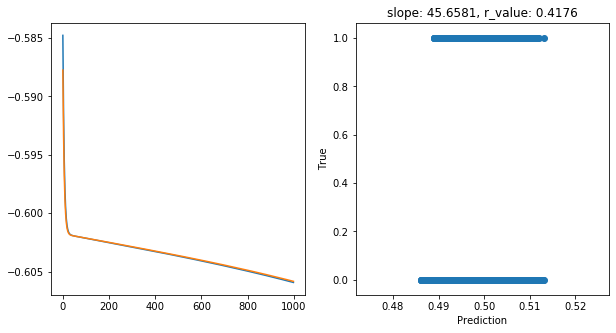

Saving model to  ./models/model_SGD_1000_lr0.05_hid_dim50

hid_dim: 50, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2582, val_loss: 0.2579, r_value: 0.4330
Epoch 100, train_loss: 0.2559, val_loss: 0.2556, r_value: 0.4400
Epoch 200, train_loss: 0.2541, val_loss: 0.2539, r_value: 0.4456
Epoch 300, train_loss: 0.2528, val_loss: 0.2527, r_value: 0.4501
Epoch 400, train_loss: 0.2519, val_loss: 0.2518, r_value: 0.4537
Epoch 500, train_loss: 0.2513, val_loss: 0.2511, r_value: 0.4565
Epoch 600, train_loss: 0.2508, val_loss: 0.2507, r_value: 0.4588
Epoch 700, train_loss: 0.2504, val_loss: 0.2503, r_value: 0.4606
Epoch 800, train_loss: 0.2502, val_loss: 0.2501, r_value: 0.4620
Epoch 900, train_loss: 0.2500, val_loss: 0.2499, r_value: 0.4632


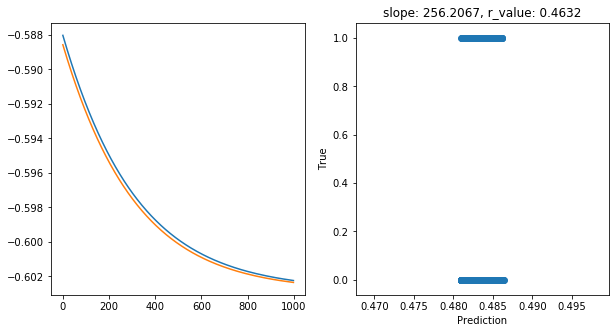

Saving model to  ./models/model_SGD_1000_lr0.001_hid_dim50

hid_dim: 100, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.2500, val_loss: 0.2502, r_value: 0.4543
Epoch 100, train_loss: 0.2573, val_loss: 0.2568, r_value: 0.4469
Epoch 200, train_loss: 0.2251, val_loss: 0.2245, r_value: 0.4513
Epoch 300, train_loss: 0.1965, val_loss: 0.1964, r_value: 0.4726
Epoch 400, train_loss: 0.1918, val_loss: 0.1912, r_value: 0.4883
Epoch 500, train_loss: 0.1897, val_loss: 0.1886, r_value: 0.4971
Epoch 600, train_loss: 0.1887, val_loss: 0.1873, r_value: 0.5017
Epoch 700, train_loss: 0.1882, val_loss: 0.1866, r_value: 0.5041
Epoch 800, train_loss: 0.1879, val_loss: 0.1862, r_value: 0.5057
Epoch 900, train_loss: 0.1876, val_loss: 0.1859, r_value: 0.5068


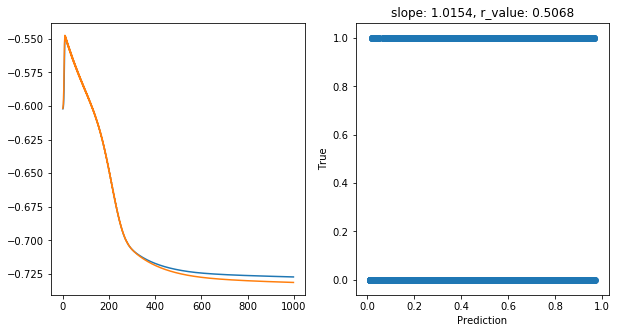

Saving model to  ./models/model_SGD_1000_lr0.75_hid_dim100

hid_dim: 100, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2525, val_loss: 0.2511, r_value: -0.1845
Epoch 100, train_loss: 0.2471, val_loss: 0.2471, r_value: 0.4080
Epoch 200, train_loss: 0.2403, val_loss: 0.2406, r_value: 0.4059
Epoch 300, train_loss: 0.2252, val_loss: 0.2258, r_value: 0.4191
Epoch 400, train_loss: 0.2084, val_loss: 0.2092, r_value: 0.4386
Epoch 500, train_loss: 0.1995, val_loss: 0.2000, r_value: 0.4590
Epoch 600, train_loss: 0.1946, val_loss: 0.1946, r_value: 0.4767
Epoch 700, train_loss: 0.1916, val_loss: 0.1911, r_value: 0.4892
Epoch 800, train_loss: 0.1898, val_loss: 0.1888, r_value: 0.4970
Epoch 900, train_loss: 0.1887, val_loss: 0.1874, r_value: 0.5019


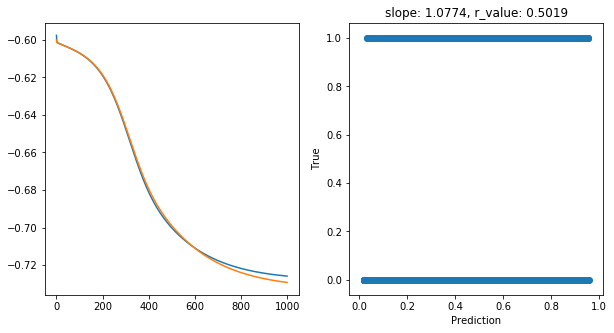

Saving model to  ./models/model_SGD_1000_lr0.5_hid_dim100

hid_dim: 100, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2532, val_loss: 0.2514, r_value: -0.0951
Epoch 100, train_loss: 0.2494, val_loss: 0.2494, r_value: 0.3980
Epoch 200, train_loss: 0.2486, val_loss: 0.2487, r_value: 0.4343
Epoch 300, train_loss: 0.2479, val_loss: 0.2479, r_value: 0.4409
Epoch 400, train_loss: 0.2470, val_loss: 0.2470, r_value: 0.4432
Epoch 500, train_loss: 0.2459, val_loss: 0.2460, r_value: 0.4445
Epoch 600, train_loss: 0.2447, val_loss: 0.2448, r_value: 0.4456
Epoch 700, train_loss: 0.2432, val_loss: 0.2433, r_value: 0.4466
Epoch 800, train_loss: 0.2414, val_loss: 0.2415, r_value: 0.4477
Epoch 900, train_loss: 0.2392, val_loss: 0.2393, r_value: 0.4488


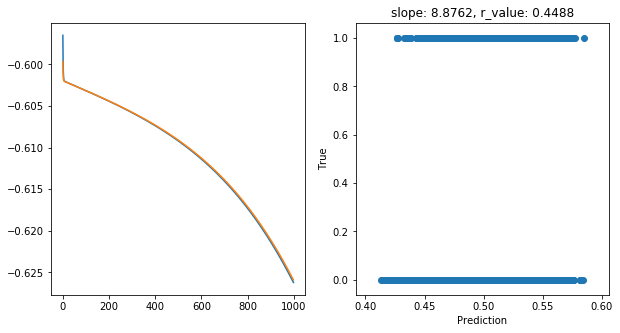

Saving model to  ./models/model_SGD_1000_lr0.1_hid_dim100

hid_dim: 100, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2545, val_loss: 0.2540, r_value: -0.2149
Epoch 100, train_loss: 0.2503, val_loss: 0.2503, r_value: -0.1830
Epoch 200, train_loss: 0.2502, val_loss: 0.2502, r_value: -0.1324
Epoch 300, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.0792
Epoch 400, train_loss: 0.2500, val_loss: 0.2500, r_value: -0.0261
Epoch 500, train_loss: 0.2499, val_loss: 0.2500, r_value: 0.0248
Epoch 600, train_loss: 0.2499, val_loss: 0.2499, r_value: 0.0720
Epoch 700, train_loss: 0.2498, val_loss: 0.2498, r_value: 0.1146
Epoch 800, train_loss: 0.2497, val_loss: 0.2497, r_value: 0.1522
Epoch 900, train_loss: 0.2496, val_loss: 0.2496, r_value: 0.1849


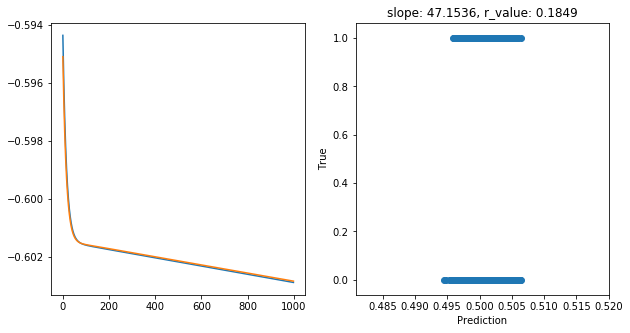

Saving model to  ./models/model_SGD_1000_lr0.01_hid_dim100

hid_dim: 100, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2529, val_loss: 0.2521, r_value: 0.0654
Epoch 100, train_loss: 0.2495, val_loss: 0.2496, r_value: 0.1986
Epoch 200, train_loss: 0.2492, val_loss: 0.2493, r_value: 0.2893
Epoch 300, train_loss: 0.2489, val_loss: 0.2490, r_value: 0.3439
Epoch 400, train_loss: 0.2486, val_loss: 0.2486, r_value: 0.3765
Epoch 500, train_loss: 0.2482, val_loss: 0.2483, r_value: 0.3967
Epoch 600, train_loss: 0.2479, val_loss: 0.2479, r_value: 0.4098
Epoch 700, train_loss: 0.2475, val_loss: 0.2475, r_value: 0.4185
Epoch 800, train_loss: 0.2470, val_loss: 0.2471, r_value: 0.4247
Epoch 900, train_loss: 0.2466, val_loss: 0.2467, r_value: 0.4291


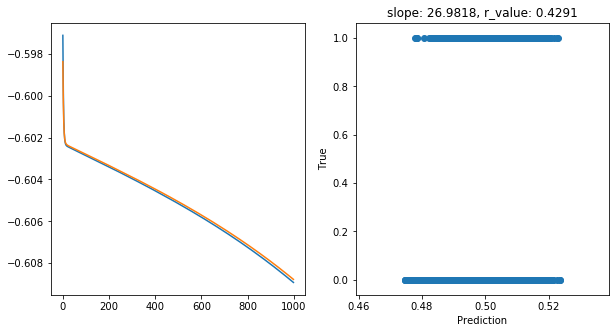

Saving model to  ./models/model_SGD_1000_lr0.05_hid_dim100

hid_dim: 100, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2505, val_loss: 0.2504, r_value: -0.2423
Epoch 100, train_loss: 0.2503, val_loss: 0.2502, r_value: -0.2270
Epoch 200, train_loss: 0.2502, val_loss: 0.2502, r_value: -0.2116
Epoch 300, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1962
Epoch 400, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1806
Epoch 500, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1648
Epoch 600, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1485
Epoch 700, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1316
Epoch 800, train_loss: 0.2501, val_loss: 0.2501, r_value: -0.1142
Epoch 900, train_loss: 0.2501, val_loss: 0.2500, r_value: -0.0960


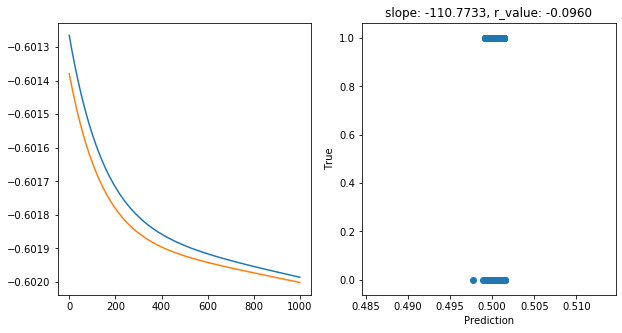

Saving model to  ./models/model_SGD_1000_lr0.001_hid_dim100


In [57]:
# model.train()
epochs = 1000
hid_dim_range = [5,25,50,100]
#hid_dim_range = [5,25]
lr_range = [0.75,0.5,0.1,0.01,0.05,0.001]
#lr_range = [0.75,0.5]

#Let's create a place to save these models, so we can 
path_to_save_models = './models'
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(4, hid_dim)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        #optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(predictors_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(predictors_test)
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test)
                all_loss_val.append(loss.item())
            
                if epoch%100==0:
                    y_pred = y_pred.detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))

        ax[1].scatter(y_pred, y_test)
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()
        
        name_to_save = os.path.join(path_to_save_models,'model_SGD_' + str(epochs) + '_lr' + str(lr) + '_hid_dim' + str(hid_dim))
        print('Saving model to ', name_to_save)
        model_state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
            }
        torch.save(model_state, name_to_save +'.pt')

### ML Perceptron CONCLUSIONS

* Highest r_value Performance: 0.5084  with hid_dim: 50, lr: 0.75
* In general the best results are obtained with the highest Learning Rate, i.e. 0.75
* Maybe increasing the number of Epochs can be benefitial?

## **GENERAL CONCLUSIONS**

* The modeling results are not good **BUT !**
* It is highly dependent on the input data.
* The quality of the input data for this experiment are not too much.

At least I have learned **A LOT** about: 
* How to manage spatial data using Python commands such as ***PyGeo*** and ***Rasterio***.
* How to generate statistical models
* which are the key parameter to be considered during the generation of the model
* How to translate these models into the final maps